In [18]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import h5py
import itertools as IT
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
from matplotlib.patches import ConnectionPatch
from matplotlib.pyplot import cm
from statistics import mean
import pandas as pd
import statistics

In [19]:
f = h5py.File('working_/rec/herdingspikes/HS2_sorted.hdf5','r') 

In [20]:
spike_time = f['times'][()]   #moment in time when each spike was detected 
sf = 30000 #sampling frequency 
maxt = max(spike_time)/sf    #divide by sf to get the time in seconds
print(maxt)

1956.9483333333333


In [21]:
spike_loc = f['data'][()]
print(spike_loc.shape)           #location of each spike in 2d

(2, 973012)


# Clustering

Number of clusters for time interval 0: 71
Number of reliable clusters for time interval 0: 56
Number of clusters for time interval 1: 73
Number of reliable clusters for time interval 1: 67
Number of clusters for time interval 2: 68
Number of reliable clusters for time interval 2: 57
Number of clusters for time interval 3: 87
Number of reliable clusters for time interval 3: 76
Number of clusters for time interval 4: 81
Number of reliable clusters for time interval 4: 70
Number of clusters for time interval 5: 81
Number of reliable clusters for time interval 5: 75
Number of clusters for time interval 6: 78
Number of reliable clusters for time interval 6: 68
Number of clusters for time interval 7: 81
Number of reliable clusters for time interval 7: 70
Number of clusters for time interval 8: 79
Number of reliable clusters for time interval 8: 67
Number of clusters for time interval 9: 77
Number of reliable clusters for time interval 9: 65
Number of clusters for time interval 10: 87
Number

Number of clusters for time interval 85: 62
Number of reliable clusters for time interval 85: 58
Number of clusters for time interval 86: 66
Number of reliable clusters for time interval 86: 59
Number of clusters for time interval 87: 71
Number of reliable clusters for time interval 87: 68
Number of clusters for time interval 88: 59
Number of reliable clusters for time interval 88: 54
Number of clusters for time interval 89: 64
Number of reliable clusters for time interval 89: 58
Number of clusters for time interval 90: 69
Number of reliable clusters for time interval 90: 62
Number of clusters for time interval 91: 72
Number of reliable clusters for time interval 91: 60
Number of clusters for time interval 92: 57
Number of reliable clusters for time interval 92: 53
Number of clusters for time interval 93: 64
Number of reliable clusters for time interval 93: 57
Number of clusters for time interval 94: 64
Number of reliable clusters for time interval 94: 59
Number of clusters for time in

([<matplotlib.axis.XTick at 0x7f1670ba5550>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

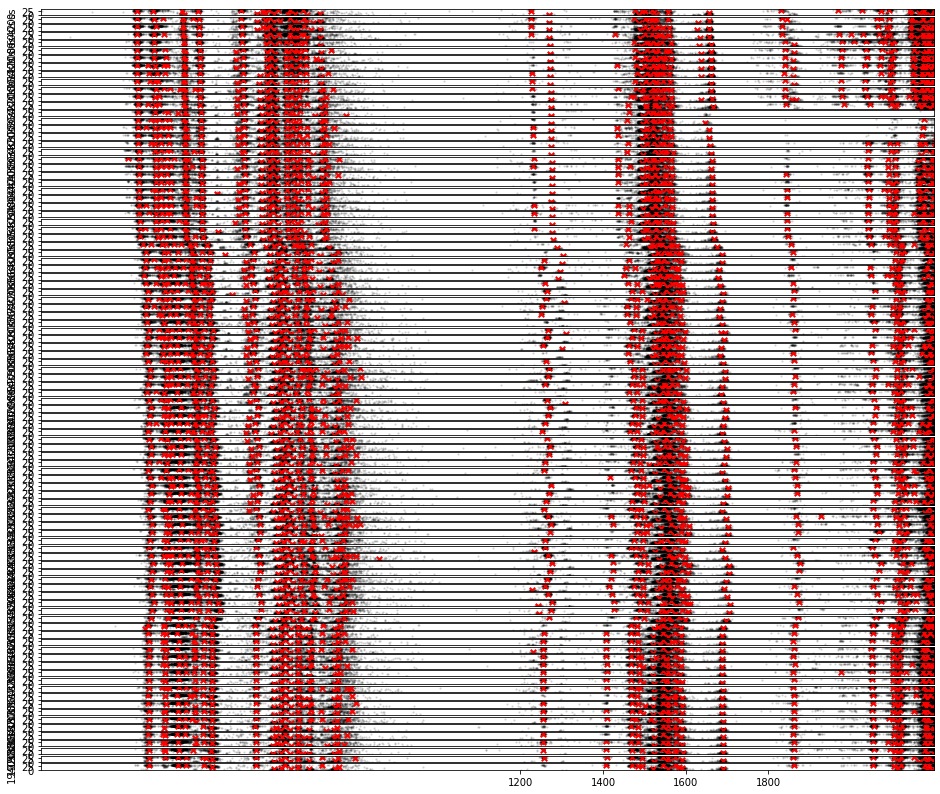

In [22]:
plt.figure(figsize=(16,14))
ms = MeanShift(bandwidth=6.5, bin_seeding=True, min_bin_freq=6)

cluster_centers_tf= []
time_frames = []
dt = 20
steps = np.arange(0,int(maxt),dt)
for j,i in enumerate(steps):
    t0=i*sf      #i*30k for every step
    t1=(i+dt)*sf  #take value of the next time step
    count = 0
    inds = np.where ((spike_time>=t0) & (spike_time<t1))[0]# & (spike_loc[1]<1800) & (spike_loc[1]>1200)
    X_clust = np.vstack((spike_loc[0,inds], spike_loc[1,inds]))
    #clustering
    ms.fit(X_clust.T)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    cc = []
    n_clusters = len(np.unique(labels))
    for k in range(len(np.unique(labels,return_counts=True)[1])):
        if np.unique(labels,return_counts=True)[1][k] > 30:
            cc.append(cluster_centers[k])
            count +=1
    print('Number of clusters for time interval %d: %d' %(j, n_clusters))
    print('Number of reliable clusters for time interval %d: %d' %(j, count))
    cc = np.array(cc)
    cluster_centers_tf.append(cc)
    time_frames.append(j)
    if i%10==0:     #for each time stamp
        ax = plt.subplot(len(steps),1,j+1)     #nrows, nrcols, plot_no
        y = X_clust[0][:]
        x = X_clust[1][:]
        
        ax.scatter(x,y, s=2, alpha=0.1, c='k')
        #ax.scatter(cluster_centers[:,1], cluster_centers[:,0], marker="x", color='r', s=30, linewidths=2)
        ax.scatter(cc[:,1], cc[:,0], marker="x", color='r', s=30, linewidths=2)
        
        plt.ylabel('{:d}s'.format(int(t0/sf)))
        plt.ylabel('{:d}s'.format(int(t0/sf)))
    
        plt.xlim((40,2200))        #Get or set the x limits of the current axes
        plt.ylim((0,40))
        plt.xticks(())
plt.xticks((1200,1400,1600,1800))   

# Matching Algorithm

In [33]:
tf_dict = {}
tf_dict_dif = {}
ll_drifts=[]
#dict_cluster_positions={}
cluster_positions={}
for t in range(len(time_frames)-1):
    
    #construct the distance matrix for every two consecutive time frames
    dist_matrix = np.zeros((len(cluster_centers_tf[t]), len(cluster_centers_tf[t+1])))
    for k,i in enumerate(cluster_centers_tf[t]):
        for l,j in enumerate(cluster_centers_tf[t+1]):
            dist_matrix[k][l] = distance.euclidean(i,j)
    
    #transform the matrix to a np array
    npdist_matrix = np.array(dist_matrix)
    list_of_indices = []
    dict_of_drifts = {}
    list_of_drifts = []
    cluster_position = {}
    while np.min(npdist_matrix)<100:
        
        #index of the minimum element of the matrix
        min_dist = np.argmin(npdist_matrix)
        #indexes of the corresponding clusters
        x,y = np.unravel_index(min_dist, np.array(npdist_matrix).shape)
        list_of_indices.append((x,y))
        #list_of_drifts.append(cluster_centers_tf[t][x] - cluster_centers_tf[t+1][y])
        list_of_drifts.append(cluster_centers_tf[t+1][y] - cluster_centers_tf[t][x])
        #dict_of_drifts[(x,y)] = cluster_centers_tf[t][x] - cluster_centers_tf[t+1][y]
        dict_of_drifts[(x,y)] = cluster_centers_tf[t+1][y] - cluster_centers_tf[t][x]
        #cluster_position[(x,y)]= ((cluster_centers_tf[t][x], cluster_centers_tf[t+1][y]))
        cluster_position[(x,y)]= ((cluster_centers_tf[t+1][y], cluster_centers_tf[t][x]))
        npdist_matrix[x,:] = 1e6
        npdist_matrix[:,y] = 1e6
        
    tf_dict[(t,t+1)] = list_of_indices
    tf_dict_dif[(t,t+1)] = dict_of_drifts
    cluster_positions[(t,t+1)] = cluster_position
    ll_drifts.append(list_of_drifts)

# Visualizations

/disk/scratch/rarest/anaconda3/envs/spiketutorial/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


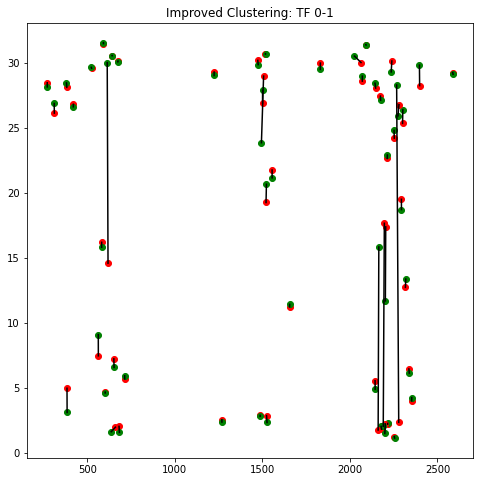

In [49]:
color=iter(cm.rainbow(np.linspace(0,1,20)))
plt.figure(figsize=(8,8))
for x,y in cluster_positions[0,1]:
    ax = plt.subplot(1,1,1)
    i = cluster_positions[(0,1)][x,y][0] #clsuter1 from pair
    j = cluster_positions[(0,1)][x,y][1] #cluster2 from pair
    #c=next(color)
    ax.scatter(i[1],i[0], c = 'red') #,color=c)
    ax.scatter(j[1],j[0], c = 'green')  #,color=c)
    plt.plot([i[1],j[1]],[i[0],j[0]],'k-')
#plt.xlim((0,40))       
#plt.ylim((1200,1800))
plt.title('Improved Clustering: TF {:d}-{:d}'.format(0,1))
plt.show()

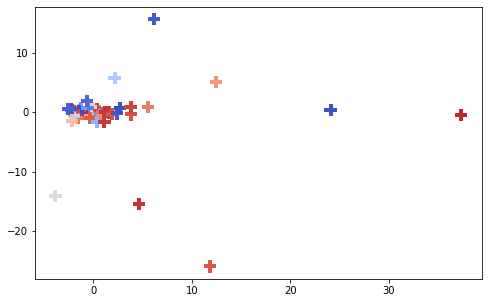

In [8]:
#shows whether all clusters move to the same direction
plt.figure(figsize=(8,5))
positions=[]
ax=[]
ay=[]
for x,y in tf_dict_dif[0,1]:
    ax.append(tf_dict_dif[0,1][x,y][1])
    ay.append(tf_dict_dif[0,1][x,y][0])
    positions.append(cluster_positions[0,1][x,y][1][0])
plt.scatter(ax,ay,s=150,marker='+',c=positions,linewidths=4, cmap=plt.cm.coolwarm)

# Average Disp

In [34]:
dict_avg_disp = {}
dict_std = {}
for t in range(len(time_frames)-1):
    distances = []
    for x,y in tf_dict_dif[t,t+1]:
        distances.append(tf_dict_dif[t,t+1][x,y])
    npdistances=np.array(distances)
    dict_avg_disp[t,t+1] = npdistances.mean(axis=0)
    dict_std[t,t+1] = np.std(npdistances,axis=0) 

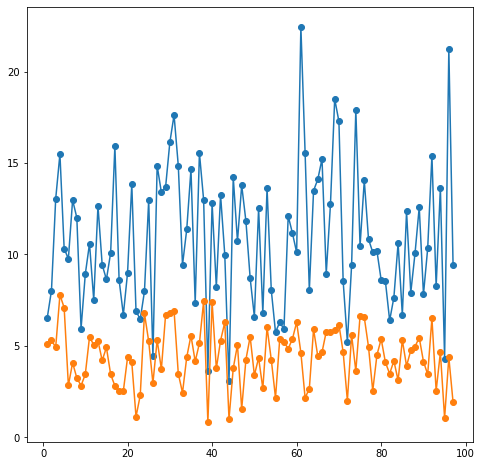

In [58]:
plt.figure(figsize=(8,8))
plt.plot(np.array(time_frames)[1:], [dict_std[t,t+1][1] for t in range(len(time_frames)-1)],'o-')   #horizontal drift
plt.plot(np.array(time_frames)[1:], [dict_std[t,t+1][0] for t in range(len(time_frames)-1)],'o-')   #vertical drift

Text(0, 0.5, 'Avg Displacement')

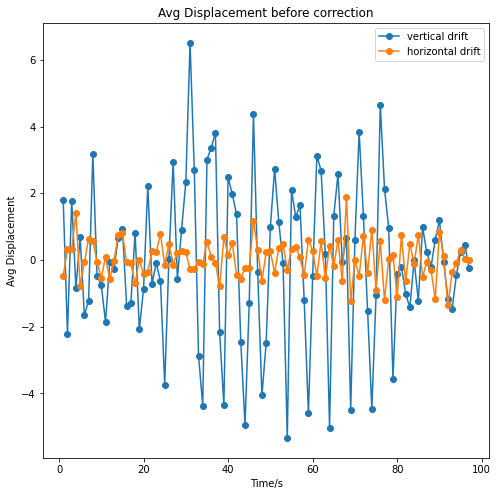

In [35]:
plt.figure(figsize=(8,8))
#for t in range(len(time_frames)-1):
    #ax = plt.subplot(1,1,1)
#    plt.scatter(time_frames[t], dict_avg_disp[t,t+1][0])
plt.plot(np.array(time_frames)[1:], [dict_avg_disp[t,t+1][1] for t in range(len(time_frames)-1)],'o-')   #horizontal drift
plt.plot(np.array(time_frames)[1:], [dict_avg_disp[t,t+1][0] for t in range(len(time_frames)-1)],'o-')   #vertical drift
plt.legend(['vertical drift', 'horizontal drift'], loc = "upper right")
plt.title('Avg Displacement before correction')
plt.xlabel('Time/s')
plt.ylabel('Avg Displacement')
#plt.ylim((-2.5, 2.0))

# Cleaned Data

In [36]:
cleaned_data = {}
ll_of_disp=[]
for t in range(len(time_frames)-1):
    cleaned_data_dict={}
    list_of_disp = []
    for x,y in tf_dict_dif[t,t+1]:
        y_threshold = (dict_avg_disp[t,t+1][0] - dict_std[t,t+1][0]/2, dict_avg_disp[t,t+1][0] + dict_std[t,t+1][0]/2)
        x_threshold = (dict_avg_disp[t,t+1][1] - dict_std[t,t+1][1]/2, dict_avg_disp[t,t+1][1] + dict_std[t,t+1][1]/2)
        if tf_dict_dif[t,t+1][x,y][0] > y_threshold[0] and tf_dict_dif[t,t+1][x,y][0] < y_threshold[1] and tf_dict_dif[t,t+1][x,y][1] > x_threshold[0] and tf_dict_dif[t,t+1][x,y][1] < x_threshold[1]:
            cleaned_data_dict[x,y] = tf_dict_dif[t,t+1][x,y]
            list_of_disp.append(tf_dict_dif[t,t+1][x,y])
    cleaned_data[(t,t+1)] = cleaned_data_dict
    ll_of_disp.append(list_of_disp)

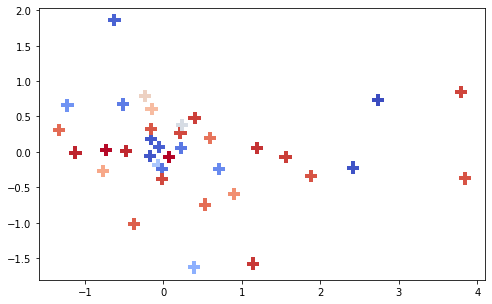

In [10]:
#shows whether all clusters move to the same direction
plt.figure(figsize=(8,5))
positions=[]
ax=[]
ay=[]
for x,y in cleaned_data[0,1]:
    ax.append(cleaned_data[0,1][x,y][1])
    ay.append(cleaned_data[0,1][x,y][0])
    positions.append(cluster_positions[0,1][x,y][1][0])
plt.scatter(ax,ay,s=150,marker='+',c=positions,linewidths=4, cmap=plt.cm.coolwarm)
#plt.scatter(ax,ay,s=150,marker='+',c='r',linewidths=4)

In [37]:
cleaned_avg_disp = {}
cleaned_std = {}
for t in range(len(time_frames)-1):
    dist = []
    for x,y in cleaned_data[t,t+1]:
        dist.append(cleaned_data[t,t+1][x,y])
    npdist=np.array(dist)
    cleaned_avg_disp[t,t+1] = npdist.mean(axis=0)
    cleaned_std[t,t+1] = np.std(npdist,axis=0) 

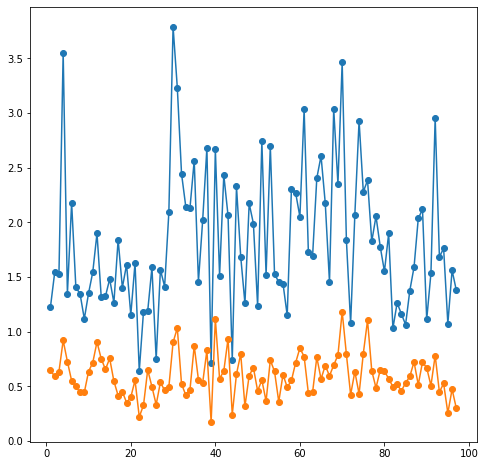

In [64]:
plt.figure(figsize=(8,8))
plt.plot(np.array(time_frames)[1:], [cleaned_std[t,t+1][1] for t in range(len(time_frames)-1)],'o-') 
plt.plot(np.array(time_frames)[1:], [cleaned_std[t,t+1][0] for t in range(len(time_frames)-1)],'o-')   

In [136]:
clean_avg_disp_before_correction = cleaned_avg_disp

Text(0.5, 0, 'Time/s')

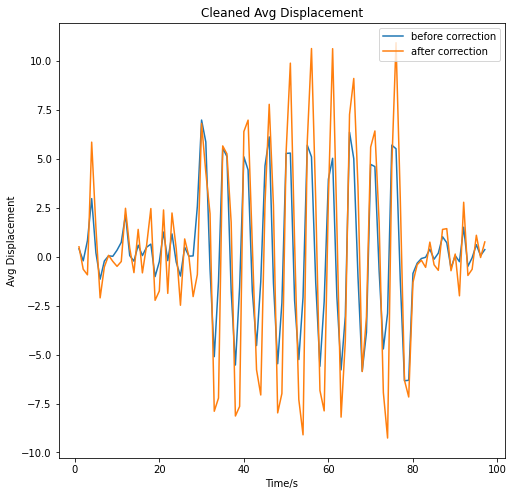

In [145]:
plt.figure(figsize=(8,8))
plt.plot(np.array(time_frames)[1:], [clean_avg_disp_before_correction[t,t+1][1] for t in range(len(time_frames)-1)]) 
plt.plot(np.array(time_frames)[1:], [cleaned_avg_disp[t,t+1][1] for t in range(len(time_frames)-1)])  
plt.legend(['before correction', 'after correction'], loc = "upper right")
plt.title('Cleaned Avg Displacement')
plt.ylabel('Avg Displacement')
plt.xlabel('Time/s')
#plt.ylim((-8, 6))  #scaled
#plt.ylim((-2, 2))  #unscaled

Text(0.5, 0, 'Time/s')

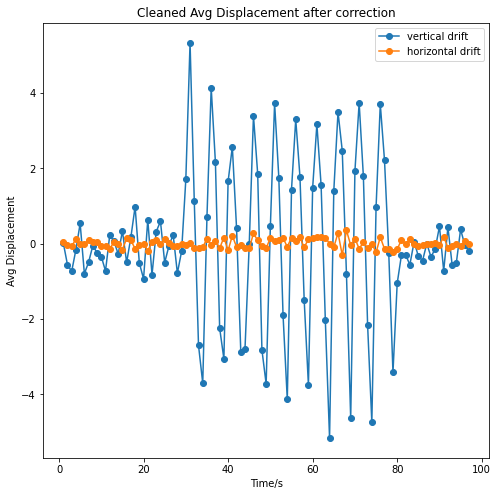

In [38]:
plt.figure(figsize=(8,8))
plt.plot(np.array(time_frames)[1:], [cleaned_avg_disp[t,t+1][1] for t in range(len(time_frames)-1)],'o-')   #horizontal drift
plt.plot(np.array(time_frames)[1:], [cleaned_avg_disp[t,t+1][0] for t in range(len(time_frames)-1)],'o-')   #vertical drift
plt.legend(['vertical drift', 'horizontal drift'], loc = "upper right")
plt.title('Cleaned Avg Displacement after correction')
plt.ylabel('Avg Displacement')
plt.xlabel('Time/s')
#plt.ylim((-8, 6))  #scaled
#plt.ylim((-2, 2))  #unscaled

Text(0.5, 0, 'Time/s')

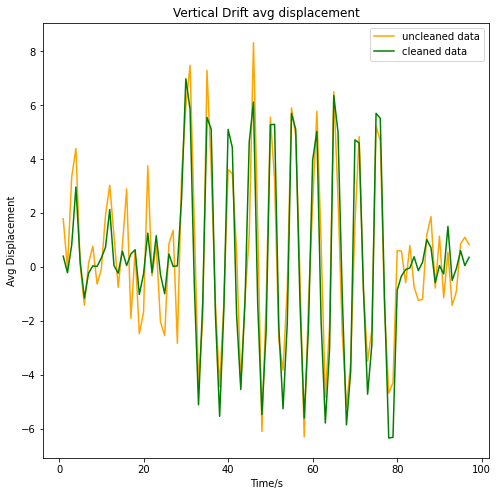

In [88]:
plt.figure(figsize=(8,8))
plt.plot(np.array(time_frames)[1:], [dict_avg_disp[t,t+1][1] for t in range(len(time_frames)-1)], color='orange')  
plt.plot(np.array(time_frames)[1:], [cleaned_avg_disp[t,t+1][1] for t in range(len(time_frames)-1)], color='green') 
plt.legend(['uncleaned data', 'cleaned data'], loc = "upper right")
plt.title('Vertical Drift avg displacement')
plt.ylabel('Avg Displacement')
plt.xlabel('Time/s')

Text(0.5, 0, 'Time/s')

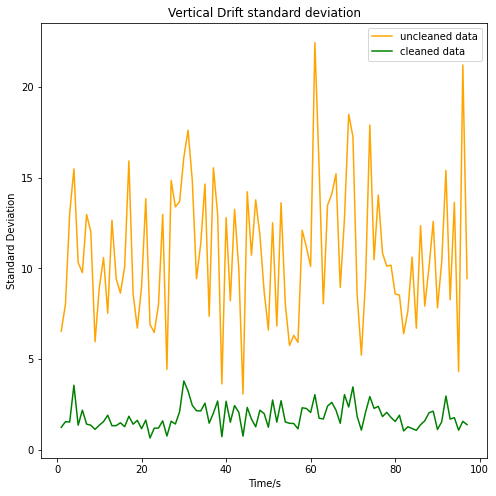

In [76]:
plt.figure(figsize=(8,8))
plt.plot(np.array(time_frames)[1:], [dict_std[t,t+1][1] for t in range(len(time_frames)-1)], color='orange')  #uncleaned
plt.plot(np.array(time_frames)[1:], [cleaned_std[t,t+1][1] for t in range(len(time_frames)-1)], color='green') #cleaned
plt.legend(['uncleaned data', 'cleaned data'], loc = "upper right")
plt.title('Vertical Drift standard deviation')
plt.ylabel('Standard Deviation')
plt.xlabel('Time/s')

# Drift correction by Avg Disp

In [146]:
#cleaned data
dt=20
sf = 30000
maxt = np.max(spike_time)/sf
steps = np.arange(0,maxt*sf,dt*sf)
cumulative_displacements = np.cumsum([np.mean(np.array(d), axis=0) for d in ll_of_disp], axis=0)
x = np.interp(np.arange(0,maxt*sf+1), steps[1:], np.array(cumulative_displacements)[:,0])
y = np.interp(np.arange(0,maxt*sf+1), steps[1:], np.array(cumulative_displacements)[:,1])

In [138]:
cumulative_displacements_before_correction = cumulative_displacements

Text(0, 0.5, 'Cumulative displacement')

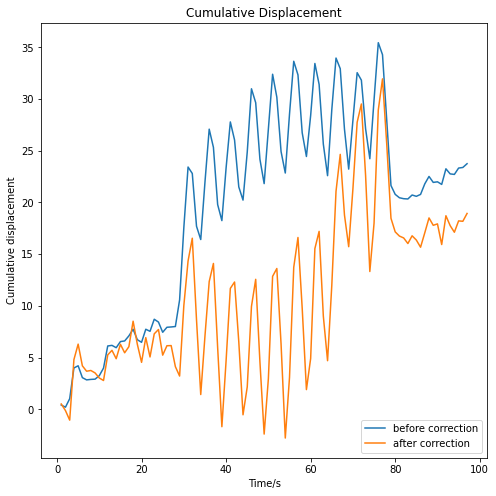

In [150]:
#cleaned data
plt.figure(figsize=(8,8))
plt.plot(np.array(time_frames)[1:], [cumulative_displacements_before_correction[t][1] for t in range(len(time_frames)-1)])  
plt.plot(np.array(time_frames)[1:], [cumulative_displacements[t][1] for t in range(len(time_frames)-1)])  
plt.legend(['before correction', 'after correction'], loc = "lower right")
plt.title('Cumulative Displacement')
#plt.ylim((-8, 20))  #scaled
plt.xlabel('Time/s')
plt.ylabel('Cumulative displacement')

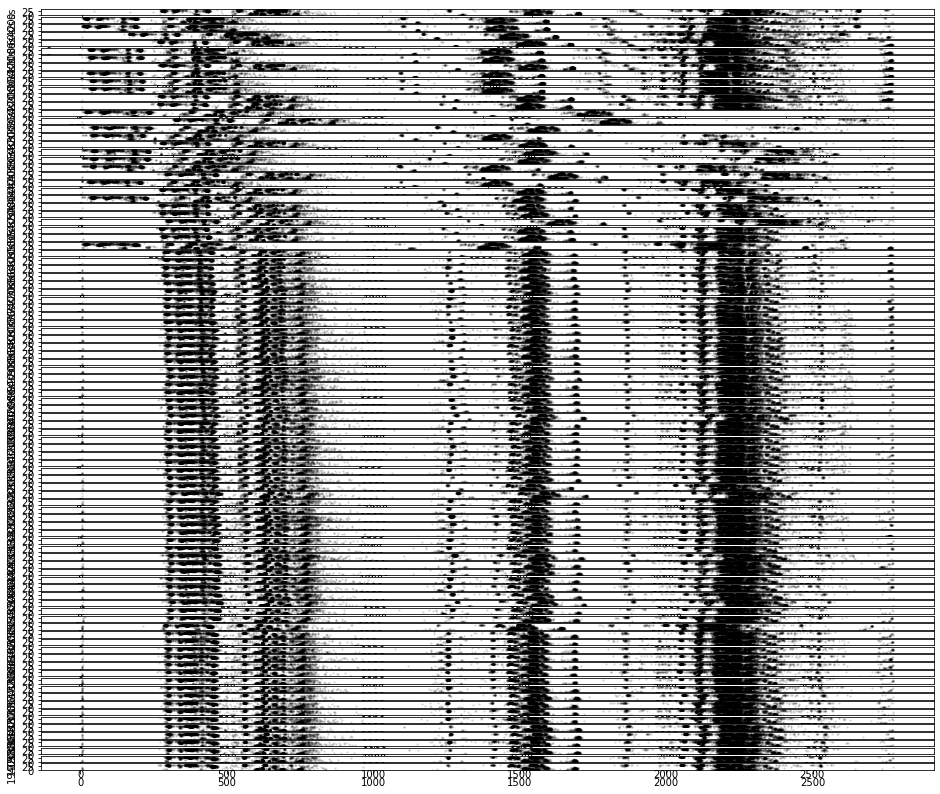

In [139]:
plt.figure(figsize=(16,14))         
l_corrected = np.copy(spike_loc)
dt = 20
steps = np.arange(0,int(maxt),dt)
for j,i in enumerate(steps):        
    t0=i*sf         
    t1= (i+dt)*sf  
    inds = np.where ((spike_time>=t0) & (spike_time<t1))[0]
    if j<len(time_frames)-1:
        l_corrected[0][inds] = l_corrected[0][inds] - cleaned_avg_disp[j, j+1][0]
        l_corrected[1][inds] = l_corrected[1][inds] - cleaned_avg_disp[j, j+1][1]
    if i%10==0:
        ax = plt.subplot(len(steps),1,j+1)
        y = l_corrected[0][inds]
        x = l_corrected[1][inds]
        ax.scatter(x,y, s=2, alpha=0.1, c='k')
        
        plt.ylabel('{:d}s'.format(int(t0/sf)))
        #plt.xlim((40,2200))       
        plt.ylim((0,40))
        #plt.xticks(())       

# Drift correction by interpolation

In [164]:
#uncleaned data
dt=20
sf = 30000
maxt = np.max(spike_time)/sf
steps = np.arange(0,maxt*sf,dt*sf)
cumulative_displacements_uncleaned = np.cumsum([np.mean(np.array(d), axis=0) for d in ll_drifts], axis=0)
x = np.interp(np.arange(0,maxt*sf+1), steps[1:], np.array(cumulative_displacements_uncleaned)[:,0])
y = np.interp(np.arange(0,maxt*sf+1), steps[1:], np.array(cumulative_displacements_uncleaned)[:,1])

In [29]:
#cleaned data
dt=20
sf = 30000
maxt = np.max(spike_time)/sf
steps = np.arange(0,maxt*sf,dt*sf)
cumulative_displacements = np.cumsum([np.mean(np.array(d), axis=0) for d in ll_of_disp], axis=0)
x = np.interp(np.arange(0,maxt*sf+1), steps[1:], np.array(cumulative_displacements)[:,0])
y = np.interp(np.arange(0,maxt*sf+1), steps[1:], np.array(cumulative_displacements)[:,1])

In [14]:
cumulative_displacements_before_correction = cumulative_displacements

Text(0, 0.5, 'Cumulative displacement')

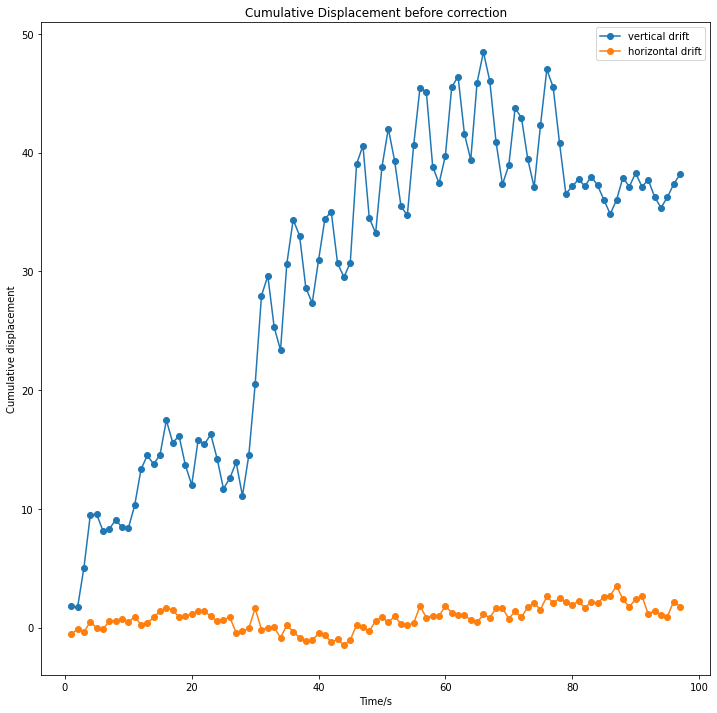

In [36]:
#uncleaned data
plt.figure(figsize=(12,12))
plt.plot(np.array(time_frames)[1:], [cumulative_displacements_uncleaned[t][1] for t in range(len(time_frames)-1)],'o-')   #horizontal drift
plt.plot(np.array(time_frames)[1:], [cumulative_displacements_uncleaned[t][0] for t in range(len(time_frames)-1)],'o-')   #vertical drift
plt.legend(['vertical drift', 'horizontal drift'], loc = "upper right")
plt.title('Cumulative Displacement before correction')
#plt.ylim((-8, 20))  #scaled
plt.xlabel('Time/s')
plt.ylabel('Cumulative displacement')

Text(0, 0.5, 'Cumulative displacement')

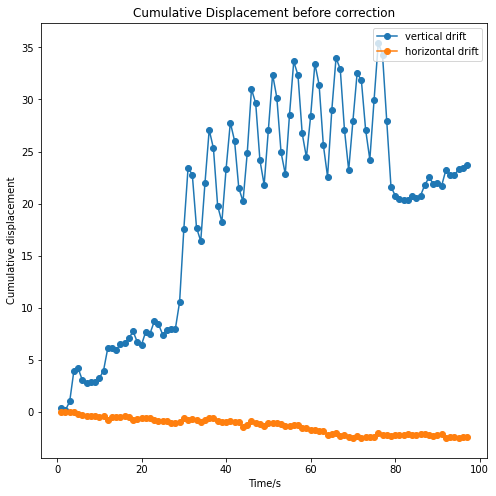

In [30]:
#cleaned data
plt.figure(figsize=(8,8))
plt.plot(np.array(time_frames)[1:], [cumulative_displacements[t][1] for t in range(len(time_frames)-1)],'o-')   #horizontal drift
plt.plot(np.array(time_frames)[1:], [cumulative_displacements[t][0] for t in range(len(time_frames)-1)],'o-')   #vertical drift
plt.legend(['vertical drift', 'horizontal drift'], loc = "upper right")
plt.title('Cumulative Displacement before correction')
#plt.ylim((-5, 30))  #scaled
plt.xlabel('Time/s')
plt.ylabel('Cumulative displacement')

Text(0, 0.5, 'Cumulative displacement')

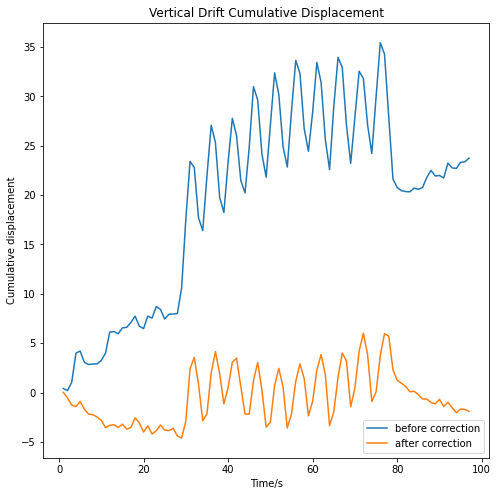

In [20]:
plt.figure(figsize=(8,8))
plt.plot(np.array(time_frames)[1:], [cumulative_displacements_before_correction[t][1] for t in range(len(time_frames)-1)]) 
plt.plot(np.array(time_frames)[1:], [cumulative_displacements[t][1] for t in range(len(time_frames)-1)])
plt.legend(['before correction', 'after correction'], loc = "lower right")
plt.title('Vertical Drift Cumulative Displacement')
#plt.ylim((-8, 20))  #scaled
plt.xlabel('Time/s')
plt.ylabel('Cumulative displacement')

In [31]:
interpolated_drift = np.vstack((x,y))
l_corrected = np.copy(spike_loc)
l_corrected[0] = l_corrected[0] - interpolated_drift[0][spike_time]
l_corrected[1] = l_corrected[1] - interpolated_drift[1][spike_time]

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(np.array(time_frames)[1:], [cumulative_displacements_uncleaned[t][1] for t in range(len(time_frames)-1)], color = 'orange') 
plt.plot(np.array(time_frames)[1:], [cumulative_displacements[t][1] for t in range(len(time_frames)-1)], color = 'green')
plt.legend(['uncleaned data', 'cleaned data'], loc = "lower right")
plt.title('Vertical Drift Cumulative Displacement')
#plt.ylim((-8, 20))  #scaled
plt.xlabel('Time/s')
plt.ylabel('Cumulative displacement')

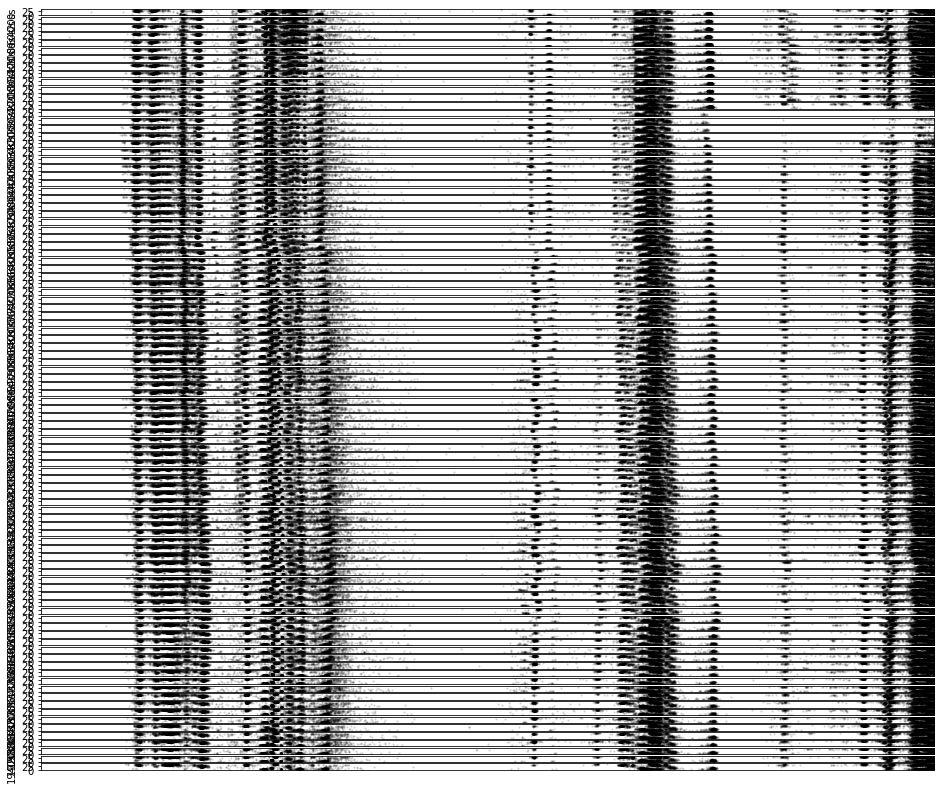

In [19]:
plt.figure(figsize=(16,14))
dt = 20
steps = np.arange(0,int(maxt),dt)
for j,i in enumerate(steps):         
    t0=i*sf        
    t1= (i+dt)*sf  
    
    inds = np.where ((spike_time>=t0) & (spike_time<t1))[0]# & (spike_loc[1]<1800) & (spike_loc[1]>1200)
    if i%10==0:
        ax = plt.subplot(len(steps),1,j+1)     
        y = l_corrected[0][inds]
        x = l_corrected[1][inds]
        ax.scatter(x,y, s=2, alpha=0.1, c='k')
        
        plt.ylabel('{:d}s'.format(int(t0/sf)))
        plt.xlim((40,2200))       
        plt.ylim((0,40))
        plt.xticks(())
#plt.xticks((1200,1400,1600,1800))

# Reclustering

Number of clusters for time interval 0: 69
Number of reliable clusters for time interval 0: 58
Number of clusters for time interval 1: 69
Number of reliable clusters for time interval 1: 64
Number of clusters for time interval 2: 66
Number of reliable clusters for time interval 2: 56
Number of clusters for time interval 3: 81
Number of reliable clusters for time interval 3: 69
Number of clusters for time interval 4: 78
Number of reliable clusters for time interval 4: 70
Number of clusters for time interval 5: 82
Number of reliable clusters for time interval 5: 75
Number of clusters for time interval 6: 76
Number of reliable clusters for time interval 6: 68
Number of clusters for time interval 7: 81
Number of reliable clusters for time interval 7: 68
Number of clusters for time interval 8: 78
Number of reliable clusters for time interval 8: 69
Number of clusters for time interval 9: 75
Number of reliable clusters for time interval 9: 64
Number of clusters for time interval 10: 80
Number

Number of clusters for time interval 85: 60
Number of reliable clusters for time interval 85: 56
Number of clusters for time interval 86: 66
Number of reliable clusters for time interval 86: 61
Number of clusters for time interval 87: 71
Number of reliable clusters for time interval 87: 66
Number of clusters for time interval 88: 60
Number of reliable clusters for time interval 88: 51
Number of clusters for time interval 89: 65
Number of reliable clusters for time interval 89: 57
Number of clusters for time interval 90: 71
Number of reliable clusters for time interval 90: 63
Number of clusters for time interval 91: 68
Number of reliable clusters for time interval 91: 63
Number of clusters for time interval 92: 61
Number of reliable clusters for time interval 92: 55
Number of clusters for time interval 93: 63
Number of reliable clusters for time interval 93: 56
Number of clusters for time interval 94: 65
Number of reliable clusters for time interval 94: 59
Number of clusters for time in

([<matplotlib.axis.XTick at 0x7f1670000390>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

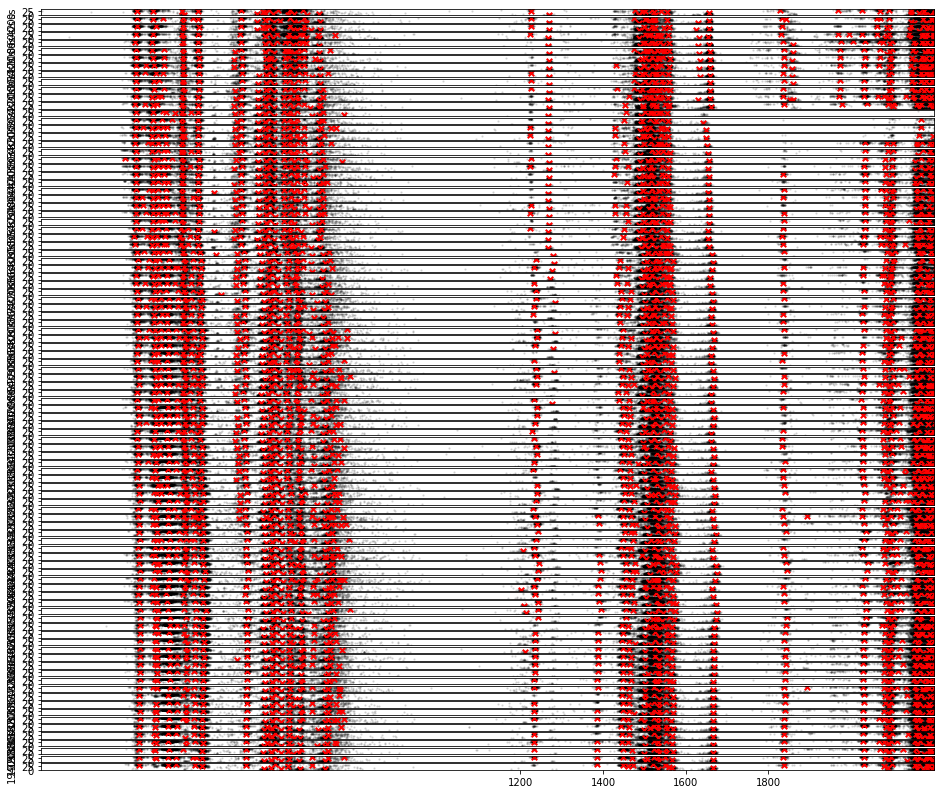

In [32]:
plt.figure(figsize=(16,14))
ms = MeanShift(bandwidth=6.5, bin_seeding=True, min_bin_freq=6)

cluster_centers_tf= []
time_frames = []
dt = 20
steps = np.arange(0,int(maxt),dt)
for j,i in enumerate(steps):
    t0=i*sf      #i*30k for every step
    t1=(i+dt)*sf  #take value of the next time step
    count = 0
    inds = np.where ((spike_time>=t0) & (spike_time<t1))[0]# & (spike_loc[1]<1800) & (spike_loc[1]>1200)
    X_clust = np.vstack((l_corrected[0,inds], l_corrected[1,inds]))
    #clustering
    ms.fit(X_clust.T)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    cc = []
    n_clusters = len(np.unique(labels))
    for k in range(len(np.unique(labels,return_counts=True)[1])):
        if np.unique(labels,return_counts=True)[1][k] > 30:
            cc.append(cluster_centers[k])
            count +=1
    print('Number of clusters for time interval %d: %d' %(j, n_clusters))
    print('Number of reliable clusters for time interval %d: %d' %(j, count))
    cc = np.array(cc)
    cluster_centers_tf.append(cc)
    time_frames.append(j)
    if i%10==0:     #for each time stamp
        ax = plt.subplot(len(steps),1,j+1)     #nrows, nrcols, plot_no
        y = X_clust[0][:]
        x = X_clust[1][:]
        
        ax.scatter(x,y, s=2, alpha=0.1, c='k')
        #ax.scatter(cluster_centers[:,1], cluster_centers[:,0], marker="x", color='r', s=30, linewidths=2)
        ax.scatter(cc[:,1], cc[:,0], marker="x", color='r', s=30, linewidths=2)
        
        plt.ylabel('{:d}s'.format(int(t0/sf)))
        plt.ylabel('{:d}s'.format(int(t0/sf)))
    
        plt.xlim((40,2200))        #Get or set the x limits of the current axes
        plt.ylim((0,40))
        plt.xticks(())
plt.xticks((1200,1400,1600,1800))   